In [1]:
import os
import copy
import numpy as np
import pandas as pd

from scipy import ndimage as nd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as data

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from IPython.display import clear_output

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/home/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
!nvidia-smi

Wed May 20 14:11:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   29C    P0    33W / 250W |   1015MiB / 16280MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   26C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
device = 1

In [5]:
# here we are going to fine-tune some pretrain models on ikea dataset
# in order to make them find 
# 1) similar object 2) similar by style object 3) additive by style object
# (unlimited space for improvements)

In [6]:
input_size = 224
ikea_dataset = ImageFolder(root="ikea-master/images",
                        transform=transforms.Compose([
                            transforms.Resize(input_size),
                            transforms.CenterCrop(input_size),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]), 
                        target_transform=None, )
len(ikea_dataset)

2563

In [7]:
def get_img(img_tensor):
    means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = img * stds + means
    img = np.clip(img, 0., 1.)
    return img

0


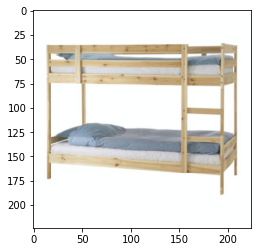

In [8]:
item = ikea_dataset[0]
print(item[1])
plt.imshow(get_img(item[0]))

In [9]:
list(enumerate(ikea_dataset.classes))

[(0, '0_bed'),
 (1, '1_chair'),
 (2, '2_clock'),
 (3, '3_couch'),
 (4, '4_dining table'),
 (5, '5_plant_pot'),
 (6, '6_objects'),
 (7, '7_room_scenes')]

In [10]:
# используем для трейна и валидации сабсет датасеты
train_classes = np.arange(6) # it should be 6!! (we didn't consider plant_pot)
idx = np.arange(len(ikea_dataset))[np.isin(ikea_dataset.targets, train_classes)]
idx_tr, idx_val = train_test_split(idx, 
                                   stratify=np.array(ikea_dataset.targets)[idx], 
                                   test_size=0.1, random_state=42)
idxs = {"train" : idx_tr, "val" : idx_val}
len(idx_tr), len(idx_val)

(433, 49)

In [11]:
print("Initializing Datasets and Dataloaders")
batch_size = 100

# Create training and validation datasets
image_datasets = {}
for m in ['train', 'val']:
    d = data.Subset(ikea_dataset, idxs[m])
#     d.transform = data_transforms[m]
    image_datasets[m] = d

# Create training and validation dataloaders
dataloaders_dict = {m: torch.utils.data.DataLoader(
    image_datasets[m], batch_size=batch_size, shuffle=True
) for m in ['train', 'val']}

Initializing Datasets and Dataloaders


In [12]:
# для начала просто возьмем предобученную сетку
# и посмотрим, как мы умеем классифицировать объекты

In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [14]:
class EmbeddingNet(nn.Module):
    def __init__(self, pretrained_model, n_fc_units=128, embedding_size=128):
        super(EmbeddingNet, self).__init__()
        self.n_fc_units = n_fc_units
        self.embedding_size = embedding_size
        
        self.convnet = pretrained_model
        set_parameter_requires_grad(self.convnet, feature_extracting=True)
        n_features = self.convnet.fc.in_features
        
        self.convnet.fc = nn.Sequential(
            nn.Linear(n_features, n_fc_units),
            nn.ReLU(inplace=True),
            nn.Linear(n_fc_units, embedding_size)
        )

    def forward(self, x):
        output = self.convnet(x)
        return output

    def get_embedding(self, x):
        return self.forward(x)

In [ ]:
# [todo] parallel embedding net - extraction of low-level features

In [15]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.ReLU()
        self.fc = nn.Linear(self.embedding_net.embedding_size, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = self.fc(output) # logits, not probs!!
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [16]:
def train_model(model, dataloaders, criterion, optimizer, n_epochs=25):
    
    def plot_results(epoch):
        clear_output(True)
        print("EPOCH {}".format(epoch))
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.plot(train_losses, label="train")
        plt.plot(val_losses, label="val")
        plt.legend()
        plt.subplot(122)
        plt.plot(train_acc, label="train")
        plt.plot(val_acc, label="val")
        plt.ylim(0., 1.)
        plt.legend()
        plt.show()
        print('{} Train: Loss: {:.4f} Acc: {:.4f}'.format(phase, train_losses[-1], train_acc[-1]))
        print('{} Val: Loss: {:.4f} Acc: {:.4f}'.format(phase, val_losses[-1], val_acc[-1]))

    since = time.time()
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(n_epochs):        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)            
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
        plot_results(epoch)
            
    return model, val_acc

In [28]:
n_epochs = 500
lr = 5e-5
n_classes = len(ikea_dataset.classes)
n_fc_units = 256
embedding_size = 256

pretrained_model = models.resnet18(pretrained=True)
embedding_net = EmbeddingNet(pretrained_model, n_fc_units=n_fc_units, embedding_size=embedding_size)
clf_model = ClassificationNet(embedding_net, n_classes)
clf_model = clf_model.to(device)

params_to_update = clf_model.parameters()
print("Params to learn:")
# feature_extract == True
params_to_update = []
for name, param in clf_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)
clf_opt = torch.optim.Adam(params_to_update, lr=lr)

criterion = nn.CrossEntropyLoss()

Params to learn:
	 embedding_net.convnet.fc.0.weight
	 embedding_net.convnet.fc.0.bias
	 embedding_net.convnet.fc.2.weight
	 embedding_net.convnet.fc.2.bias
	 fc.weight
	 fc.bias


EPOCH 225


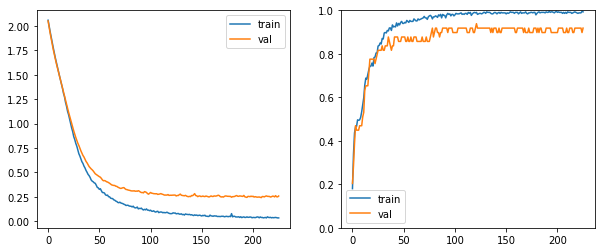

  0%|          | 0/5 [00:00<?, ?it/s]

val Train: Loss: 0.0324 Acc: 0.9931
val Val: Loss: 0.2569 Acc: 0.9184


 40%|████      | 2/5 [00:03<00:05,  1.70s/it]

In [ ]:
# Setup the loss fxn
# Train and evaluate
clf_model, val_acc = train_model(clf_model, dataloaders_dict, criterion, clf_opt, n_epochs=n_epochs)

EPOCH 99


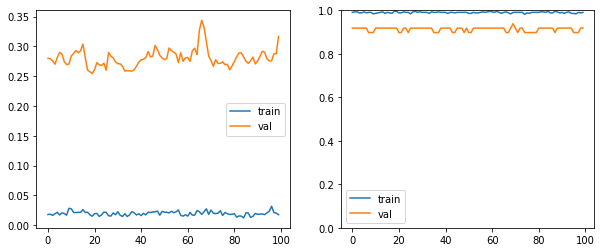

val Train: Loss: 0.0177 Acc: 0.9908
val Val: Loss: 0.3166 Acc: 0.9184


In [32]:
n_epochs = 100
clf_model, val_acc = train_model(clf_model, dataloaders_dict, criterion, clf_opt, n_epochs=n_epochs)

In [35]:
item_indices = np.arange(len(ikea_dataset))[np.array(ikea_dataset.targets) < 7]
# all ikea objects except for room scenes

In [50]:
item_indices, len(item_indices)

(array([   0,    1,    2, ..., 2344, 2345, 2346]), 2347)

In [36]:
# попробуем использовать эту сетку, чтобы найти похожие визуально товары
embeddings = []
labels = []
for i in tqdm(item_indices):
    img, l = ikea_dataset[i]
    img = img.unsqueeze(dim=0).to(device)
    img_emb = embedding_net(img)[0]
    embeddings.append(img_emb)
    labels.append(l)
embeddings = torch.stack(embeddings, dim=0).cpu().detach().numpy()
labels = np.array(labels)

100%|██████████| 2347/2347 [00:39<00:00, 59.43it/s]


In [37]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2)

embeddings_red = pca.fit_transform(embeddings)
embeddings_2d = tsne.fit_transform(embeddings_red)

In [50]:
from matplotlib.colors import rgb2hex

def get_colors(cmap, breaks):
    return [rgb2hex(cmap(bb)) for bb in breaks]
n = 2
get_colors(plt.get_cmap("viridis"), np.linspace(0, 1, n))
get_colors(plt.get_cmap("nipy_spectral"), np.linspace(0, 1, n))
get_colors(plt.get_cmap("tab20"), np.arange(n))
get_colors(plt.get_cmap("tab10"), np.arange(n))
get_colors(plt.get_cmap("Set2"), np.arange(n))

['#66c2a5', '#fc8d62']

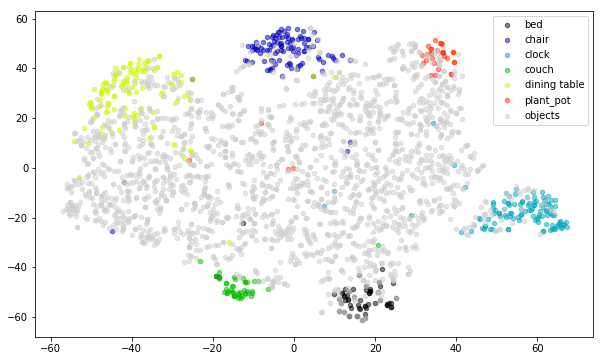

In [45]:
n = 7
cats = list(map(lambda x: "_".join(x.split("_")[1:]), ikea_dataset.classes))
colors = get_colors(plt.get_cmap("nipy_spectral"), np.linspace(0, 1, n))

plt.figure(figsize=(10, 6))

for i in range(n):
    plt.scatter(embeddings_2d[labels == i, 0], embeddings_2d[labels == i, 1], 
                c=colors[i], alpha=0.5, s=20, label=cats[i])
plt.legend()
plt.show()

In [93]:
# сохраняем модель
torch.save(clf_model.state_dict(), "./clf_model.pth")

In [46]:
# теперь попробуем взять объект и найти самые близкие к нему (по эмбеддингам)

def get_img(img_tensor):
    means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = img * stds + means
    img = np.clip(img, 0., 1.)
    return img

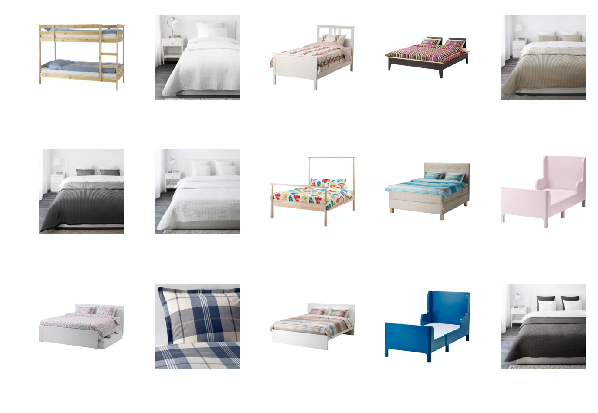

In [53]:
i = 0 #np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["902.651.09.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[j][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

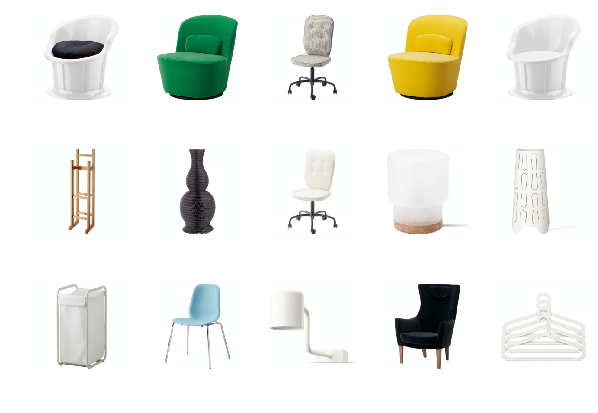

In [54]:
i = 100 #np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["902.651.09.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[j][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

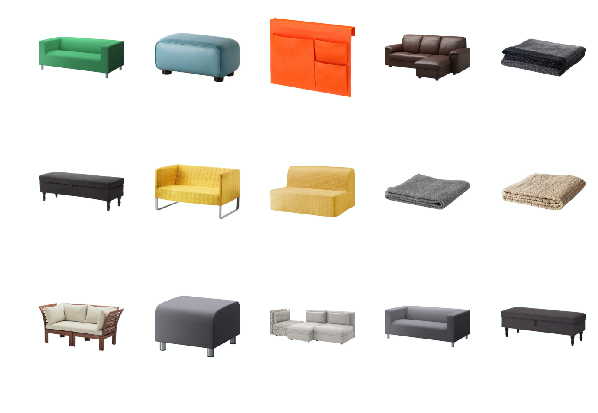

In [56]:
i = 305 #np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["902.651.09.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[j][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

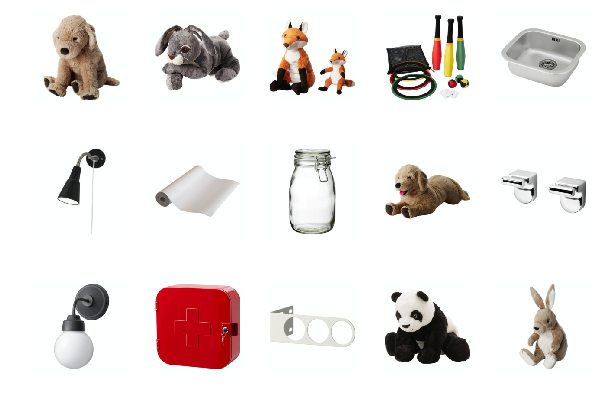

In [57]:
i = 500 #np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["902.651.09.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[j][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

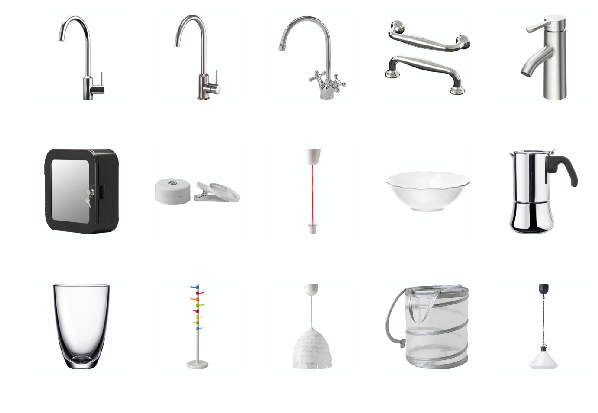

In [58]:
i = 700 #np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["902.651.09.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[j][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

In [ ]:
# теперь мы этой сеткой, которая что-то знает о товарах
# получаем эмбеддинги для наших товаров с амазона

In [17]:
import pickle

with open('./asin_to_use_main.pickle', 'rb') as handle:
    asin_to_use = pickle.load(handle)

In [18]:
len(asin_to_use)

8294

In [19]:
import os
import random
from PIL import Image 

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AmazonImgs(data.Dataset):
    """
    Arguments:
        path: path to data folder
    """
    
    def __init__(self, dir_path, transform=None, mode="sample", asin_to_use=set()):
        self.asin = [] # list of asins
        self.imgs = {} # dict {asin : [asin images]}
        self.transform = transform
        self.mode = mode
        self.asin_to_use = asin_to_use
        
        # obj = asin
        for obj in tqdm(os.listdir(dir_path)):
            if not self.asin_to_use or obj in self.asin_to_use:
                self.asin.append(obj)
                obj_path = os.path.join(dir_path, obj)
                # save the list of imgs for asin
                obj_imgs = []
                for img in os.listdir(obj_path):
                    img_path = os.path.join(dir_path, obj, img)
                    img = pil_loader(img_path)
                    obj_imgs.append(img)
                self.imgs[obj] = obj_imgs
            
    def get_asin_imgs(self, asin):
        # here we return all images for this asin
        return [self.transform(img) for img in self.imgs[asin]]
        
    def sample_asin_img(self, asin):
        # here we sample a random image from images for this asin
        img = random.sample(self.imgs[asin], 1)[0]
        return self.transform(img)
         
    def __getitem__(self, index):
        asin = self.asin[index]
        if self.mode == "sample":
            return self.sample_asin_img(asin)
        if self.mode == "all":
            return self.get_asin_imgs(asin)
        
    def __len__(self):
        return len(self.asin)

In [20]:
input_size = 224
transform=transforms.Compose([
                            transforms.CenterCrop(input_size),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

amazon_imgs = AmazonImgs(dir_path="NewCatinki/", transform=transform, mode="sample", 
                         asin_to_use=asin_to_use,
                        )
len(amazon_imgs)

100%|██████████| 20293/20293 [02:00<00:00, 168.47it/s]


8294

In [77]:
asin_embeddings = {}
# пройтись по всем объектам
for i in tqdm(range(len(amazon_imgs))):
    asin = amazon_imgs.asin[i]
    # по всем изображениям каждого объекта
    imgs = amazon_imgs.get_asin_imgs(asin)
    # получить из этого изображения эмбеддинги
    embeds = []
    for img in imgs:
        with torch.no_grad():
            img = img.unsqueeze(dim=0).to(device)
            img_emb = embedding_net(img)[0].detach().cpu()
        embeds.append(img_emb)
    # добавить их в словарь
    asin_embeddings[asin] = embeds

100%|██████████| 8294/8294 [04:38<00:00, 29.74it/s]


In [78]:
len(asin_embeddings)

8294

In [79]:
asin_embeddings = {k : v for k, v in asin_embeddings.items() if k in asin_to_use}
len(asin_embeddings)

8294

In [80]:
with open('./clf_embeddings_1.pickle', 'wb') as handle:
    pickle.dump(asin_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
asin_features = {item : asin_embeddings[item][0].numpy() for item in tqdm(asin_embeddings)}
len(asin_features)

100%|██████████| 8294/8294 [00:00<00:00, 293241.71it/s]


8294

100%|██████████| 8294/8294 [00:00<00:00, 126670.64it/s]


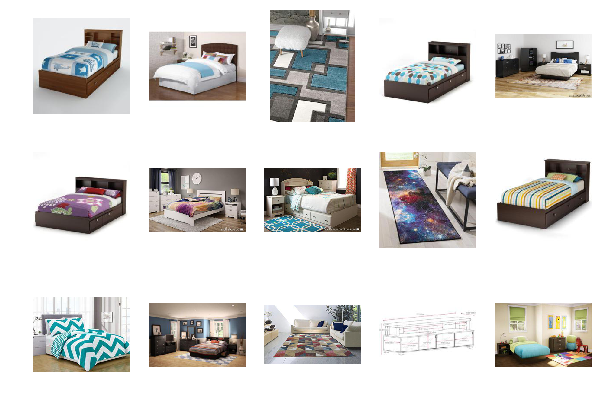

In [82]:
# i = np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["202.390.10.jpg"]).ravel()[0]
a = 'B003OR97N2'
emb_a = asin_features[a]

dist_a = {}
for j in tqdm(asin_features):
    emb_j = asin_features[j]
    dist_a[j] = ((emb_a - emb_j) ** 2).sum()
    
plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_a).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(amazon_imgs.imgs[j][0])
#     plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

100%|██████████| 8294/8294 [00:00<00:00, 80569.28it/s]


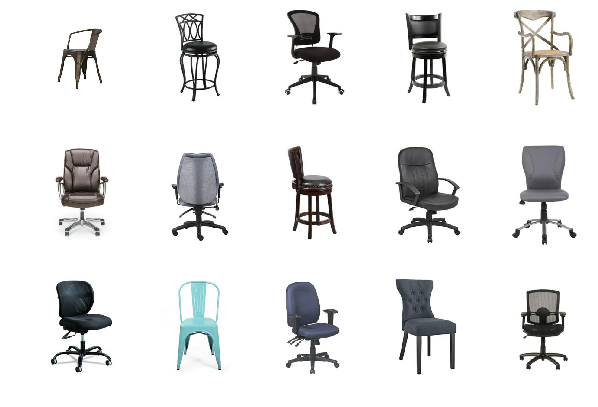

In [84]:
# i = np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["202.390.10.jpg"]).ravel()[0]
a = 'B01601K4SU'
emb_a = asin_features[a]

dist_a = {}
for j in tqdm(asin_features):
    emb_j = asin_features[j]
    dist_a[j] = ((emb_a - emb_j) ** 2).sum()
    
plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_a).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(amazon_imgs.imgs[j][0])
#     plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

100%|██████████| 8294/8294 [00:00<00:00, 89261.12it/s]


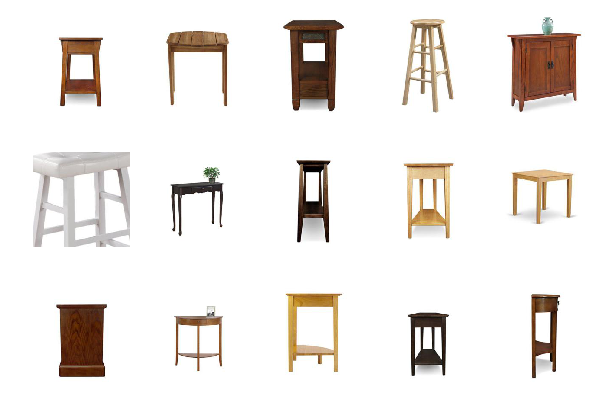

In [85]:
# i = np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["202.390.10.jpg"]).ravel()[0]
a = 'B00402S0Q0'
emb_a = asin_features[a]

dist_a = {}
for j in tqdm(asin_features):
    emb_j = asin_features[j]
    dist_a[j] = ((emb_a - emb_j) ** 2).sum()
    
plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_a).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(amazon_imgs.imgs[j][0])
#     plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

100%|██████████| 8294/8294 [00:00<00:00, 49155.59it/s]


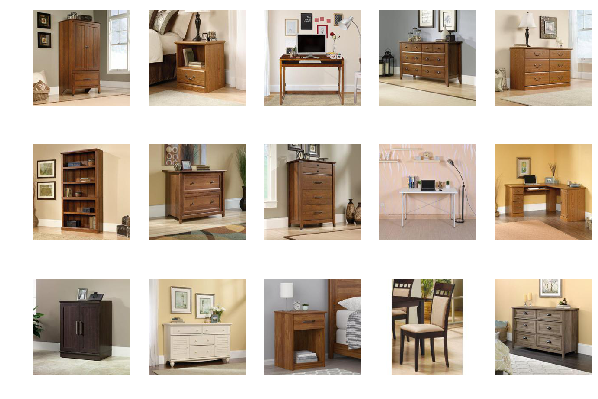

In [87]:
# i = np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["202.390.10.jpg"]).ravel()[0]
a = 'B00IA8OELK'
emb_a = asin_features[a]

dist_a = {}
for j in tqdm(asin_features):
    emb_j = asin_features[j]
    dist_a[j] = ((emb_a - emb_j) ** 2).sum()
    
plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_a).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(amazon_imgs.imgs[j][0])
#     plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

100%|██████████| 8294/8294 [00:00<00:00, 96929.62it/s]


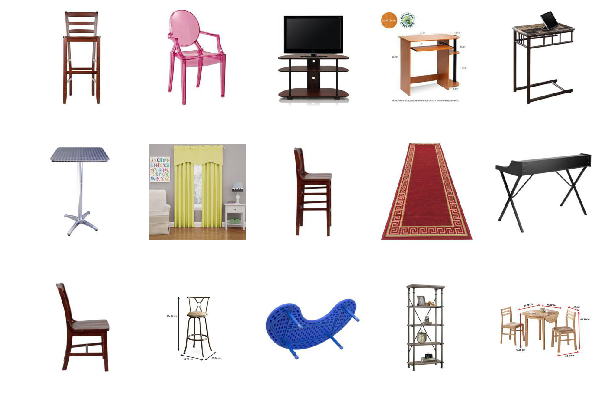

In [89]:
# i = np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["202.390.10.jpg"]).ravel()[0]
a = 'B005337YM6'
emb_a = asin_features[a]

dist_a = {}
for j in tqdm(asin_features):
    emb_j = asin_features[j]
    dist_a[j] = ((emb_a - emb_j) ** 2).sum()
    
plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_a).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(amazon_imgs.imgs[j][0])
#     plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

100%|██████████| 8294/8294 [00:00<00:00, 93227.24it/s]


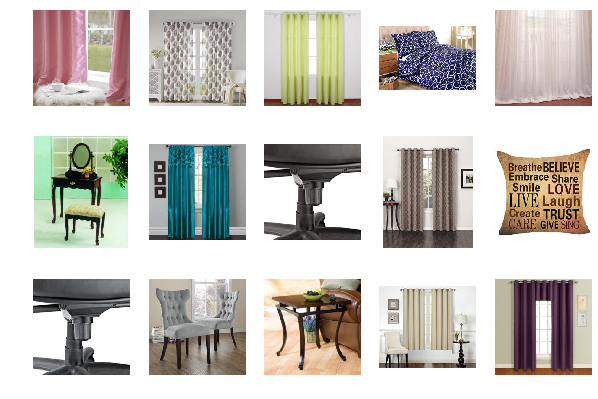

In [90]:
# i = np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["202.390.10.jpg"]).ravel()[0]
a = 'B00K1G9DNS'
emb_a = asin_features[a]

dist_a = {}
for j in tqdm(asin_features):
    emb_j = asin_features[j]
    dist_a[j] = ((emb_a - emb_j) ** 2).sum()
    
plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_a).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(amazon_imgs.imgs[j][0])
#     plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

In [ ]:
# сеть успешно находит похожие объекты, 
# но едва ли их можно назвать сочетающимися по стилю

In [ ]:
# вариант с параллельными сетками будем учить отдельно в отдельном ноутбуке?

In [ ]:
# siamese network for similarity learning

In [23]:
path = "ikea-master/text_data/item_to_room.p"
item_to_room = pd.read_pickle(path)

path = "ikea-master/text_data/room_to_items.p"
room_to_item = pd.read_pickle(path)

path = "ikea-master/text_data/categories_images_dict.p"
cats_images_dict = pd.read_pickle(path)

path = "ikea-master/text_data/products_dict.p"
products_dict = pd.read_pickle(path)

In [24]:
def get_item_number(dataset, i):
    return dataset.imgs[i][0].split("/")[-1]

In [25]:
# в ikea_dataset подтянулись все реально существующие объекты из папок
# -> в idx_to_item_number лежат индексы всех реально существующих объектов,
# в item_number_to_idx - номера всех существующих объектов

idx_to_item_number = {i : get_item_number(ikea_dataset, i) for i in range(len(ikea_dataset))}
item_number_to_idx = {item : i for i, item in idx_to_item_number.items()}
len(idx_to_item_number)

2563

In [26]:
# item_to_room - { item_number : [list of rooms] }

In [27]:
# когда мы создаем список item_number_to_room, нужно учитывать, 
# что не все объекты из списка item_to_room реально существуют в датасете
# -> нужно отфильтровать те, номера которых также представлены в item_number_to_idx
item_number_to_room = {k.split("/")[-1] : item_to_room[k] for k in item_to_room}
print(len(item_number_to_room))
item_number_to_room =  {k : v for k, v in item_number_to_room.items() if k in item_number_to_idx}
print(len(item_number_to_room))

2178
2175


In [28]:
room_to_item_number = dict()
for item in tqdm(item_number_to_room):
    rooms_with_item = item_number_to_room[item]
    for r in rooms_with_item:
        if r not in room_to_item_number:
            room_to_item_number[r] = set()
        room_to_item_number[r].add(item)

100%|██████████| 2175/2175 [00:00<00:00, 370326.02it/s]


In [29]:
related_items = {i : set() for i in item_number_to_room}
for room in tqdm(room_to_item_number):
    room_items = list(room_to_item_number[room])
    for i in range(len(room_items)):
        for j in range(len(room_items)):
            related_items[room_items[i]].add(room_items[j])

100%|██████████| 585/585 [00:00<00:00, 16982.16it/s]


In [30]:
len(related_items)

2175

In [31]:
room_scenes_idx = np.arange(len(ikea_dataset))[np.array(ikea_dataset.targets) == 7]
len(room_scenes_idx)

216

In [32]:
room_scenes = {get_item_number(ikea_dataset, i) for i in tqdm(room_scenes_idx)}
len(room_scenes)

100%|██████████| 216/216 [00:00<00:00, 160037.04it/s]


216

In [33]:
classes = {c.split("_")[1] : c for c in ikea_dataset.classes}
classes

{'bed': '0_bed',
 'chair': '1_chair',
 'clock': '2_clock',
 'couch': '3_couch',
 'dining table': '4_dining table',
 'objects': '6_objects',
 'plant': '5_plant_pot',
 'room': '7_room_scenes'}

In [34]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net, normalize=False):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net
        self.normalize = normalize

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        x = self.embedding_net(x)
        if self.normalize:
            x /= torch.sqrt((x ** 2).sum(dim=-1))
        return x


class TripletNet(nn.Module):
    def __init__(self, embedding_net, normalize=False):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        x = self.embedding_net(x)
        if self.normalize:
            x /= torch.sqrt((x ** 2).sum(dim=-1))
        return x

In [35]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [36]:
# датасет (обертка над оригинальным датасетом) для сиамиз сэмплинга

class SiameseDataset(data.Dataset):
    def __init__(self, item_dataset, 
                 idx_to_item_number,
                 item_number_to_idx,
                 related_items):
        self.item_dataset = item_dataset
        self.idx_to_item_number = idx_to_item_number
        self.item_number_to_idx = item_number_to_idx
        self.related_items = related_items
        self.all_items = set(related_items.keys())
        # добавляем индексы из икеа датасета, если эти итемы содержатся в идх_ту_итем_намбер
        self.item_indices = [i for i in range(len(item_dataset)) if (
            (i in self.idx_to_item_number) and (self.idx_to_item_number[i]) in self.all_items
        )] # короче, только индексы, которые есть в all_items (то есть которые есть в related_items)
        
    def __getitem__(self, i):
        # have i,
        # a) randomly sample j and define label based on (i, j) pair
        # OR
        # b) sample label (0 or 1) with 1/2 probability
        # and select j respectively
        
        # (b)
        item_i = self.idx_to_item_number[i]
        if item_i not in self.related_items:
            print(i, item_i)
        label = np.random.randint(0, 2)
        if label: # pos (label == 1)
            item_j = np.random.choice(list(self.related_items[item_i]))
        else: # neg (label == 0)
            item_j = np.random.choice(list(self.all_items - self.related_items[item_i]))
        j = self.item_number_to_idx[item_j]
        
        img_i, img_j = self.item_dataset[i][0], self.item_dataset[j][0]
        return (img_i, img_j), label
    
    def __len__(self):
        return len(self.item_indices)
    

class TripletDataset(data.Dataset):
    def __init__(self, item_dataset, 
                 idx_to_item_number,
                 item_number_to_idx,
                 related_items):
        self.item_dataset = item_dataset
        self.idx_to_item_number = idx_to_item_number
        self.item_number_to_idx = item_number_to_idx
        self.related_items = related_items
        self.all_items = set(related_items.keys())
        # добавляем индексы из икеа датасета, если эти итемы содержатся в идх_ту_итем_намбер
        self.item_indices = [i for i in range(len(item_dataset)) if (
            i in self.idx_to_item_number and self.idx_to_item_number[i] in self.all_items
        )] # короче, только индексы, которые есть в all_items (то есть которые есть в related_items)
        
    def __getitem__(self, i):
        # have i,
        # sample & return 
        # - j_pos (for positive example)
        # - j_neg (for negative example)
        
        item_i = self.idx_to_item_number[i]
        item_j_pos = np.random.choice(list(self.related_items[item_i]))
        item_j_neg = np.random.choice(list(self.all_items - self.related_items[item_i]))
        j_pos = self.item_number_to_idx[item_j_pos]
        j_neg = self.item_number_to_idx[item_j_neg]
        
        img_i, img_j_pos, img_j_neg = self.item_dataset[i][0], self.item_dataset[j_pos][0], self.item_dataset[j_neg][0]
        return (img_i, img_j_pos, img_j_neg), []
    
    def __len__(self):
        return len(self.item_indices)

In [37]:
# all_items = set(related_items.keys())
# for i in range(len(ikea_dataset)):
#     if not i in idx_to_item_number:
#         print(i, "not in idx_to_item_number")
#     else:
#         if not idx_to_item_number[i] in all_items:
#             print(i, idx_to_item_number[i], "not in all_items")

In [38]:
siam_ikea_dataset = SiameseDataset(ikea_dataset,
                                  idx_to_item_number,
                                  item_number_to_idx,
                                  related_items)

In [39]:
def train_one_epoch(train_loader, model, opt, criterion, metrics=[], device=device):
#     for metric in metrics:
#         metric.reset()
    model.train()
    losses = []
    
    for data, target in tqdm(train_loader):
        target = target if len(target) > 0 else None
        data = (data,) if type(data) not in (tuple, list) else data
        data, target = tuple(d.to(device) for d in data), target.to(device)
        
        outputs = model(*data)
        outputs = (outputs,) if type(outputs) not in (tuple, list) else outputs
        opt.zero_grad()
        if target is not None:
            loss = criterion(*(outputs), target)
        else:
            loss = criterion(*(outputs))
        loss.backward()
        opt.step()
        # 
        losses.append(loss.item())
        for metric in metrics:
            metric(outputs, target, loss_outputs)
            
    mean_loss = np.mean(losses)
    return mean_loss, metrics

def validate(val_loader, model, criterion, metrics=[], device=device):
#     for metric in metrics:
#         metric.reset()
    model.train()
    losses = []
    
    for data, target in tqdm(val_loader):
        target = target if len(target) > 0 else None
        data = (data,) if type(data) not in (tuple, list) else data
        data, target = tuple(d.to(device) for d in data), target.to(device)
        
        outputs = model(*data)
        outputs = (outputs,) if type(outputs) not in (tuple, list) else outputs
        if target is not None:
            loss = criterion(*(outputs), target)
        else:
            loss = criterion(*(outputs))
        # 
        losses.append(loss.item())
        for metric in metrics:
            metric(outputs, target, loss_outputs)
            
    mean_loss = np.mean(losses)
    return mean_loss, metrics

def train(train_loader, val_loader, model, opt, criterion, n_epochs, metrics=[], device=device):
    
    def plot_results(epoch):
        clear_output(True)
        print("EPOCH {}".format(epoch))
        plt.figure(figsize=(10, 4))
#         plt.subplot(121)
        plt.plot(train_losses, label="train")
        plt.plot(val_losses, label="val")
        plt.legend()
#         plt.subplot(122)
#         plt.plot(train_acc, label="train")
#         plt.plot(val_acc, label="val")
#         plt.ylim(0., 1.)
        plt.legend()
        plt.show()
        print('Train: Loss: {:.4f}'.format(train_losses[-1]))
#         print('Train: Acc: {:.4f}'.format(train_acc[-1]))
        print('Val: Loss: {:.4f}'.format(val_losses[-1]))
#         print('Val: Acc: {:.4f}'.format(val_acc[-1]))

    since = time.time()
    train_losses = []
    val_losses = []
#     train_acc = []
#     val_acc = []
    for epoch in range(n_epochs):
        train_loss, metrics = train_one_epoch(train_loader, model, opt, criterion, metrics, device)
        train_losses.append(train_loss)
        val_loss, metrics = validate(val_loader, model, criterion, metrics, device)
        val_losses.append(val_loss)
        plot_results(epoch)
            
    return model, train_losses, val_losses

In [69]:
n_epochs = 30
batch_size = 200
lr = 3e-5
n_classes = len(ikea_dataset.classes)
n_fc_units = 256
embedding_size = 256

pretrained_model = models.resnet18(pretrained=True)
embedding_net = EmbeddingNet(pretrained_model, n_fc_units=n_fc_units, embedding_size=embedding_size)
siam_model = SiameseNet(embedding_net, normalize=True)
siam_model = siam_model.to(device)

params_to_update = siam_model.parameters()
print("Params to learn:")
# feature_extract == True
params_to_update = []
for name, param in siam_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)
siam_opt = torch.optim.Adam(params_to_update, lr=lr)

criterion = ContrastiveLoss(margin=0)

Params to learn:
	 embedding_net.convnet.fc.0.weight
	 embedding_net.convnet.fc.0.bias
	 embedding_net.convnet.fc.2.weight
	 embedding_net.convnet.fc.2.bias


In [70]:
len(idx_to_item_number), len(siam_ikea_dataset.related_items)

(2563, 2175)

In [71]:
# # - в икеа_датасет подтянулось все из итемов
# # - idx_to_item_number получен проходом по элементам датасета -> в нем лежат все существующие индексы итемов

# индексы тех объектов, которые встречались в интерьерах комнат (И реально существуют)
idx = siam_ikea_dataset.item_indices
print(len(idx))
idx = [i for i in idx if ikea_dataset.targets[i] < 7]
print(len(idx))

2198
2198


In [72]:
# here we will use all the objects in dataset

# используем для обучения только те объекты, которые встречались в интерьерах комнат
# train_classes = np.arange(7)
# idx = np.arange(len(ikea_dataset))[np.isin(ikea_dataset.targets, train_classes)]
idx_tr, idx_val = train_test_split(idx, 
                                   stratify=np.array(ikea_dataset.targets)[idx], 
                                   test_size=0.1, random_state=42)
# idxs = {"train" : idx_tr, "val" : idx_val}
# len(idx_tr), len(idx_val)

# train siamese network on the whole sample
idxs = {"train" : idx, "val" : idx_val}
len(idx), len(idx_val)

(2198, 220)

In [73]:
# Create training and validation datasets
siam_image_datasets = {}
for m in ['train', 'val']:
    d = data.Subset(siam_ikea_dataset, idxs[m])
#     d.transform = data_transforms[m]
    siam_image_datasets[m] = d

# Create training and validation dataloaders
siam_dataloaders_dict = {m: torch.utils.data.DataLoader(
    siam_image_datasets[m], batch_size=batch_size, shuffle=True
) for m in ['train', 'val']}

EPOCH 29


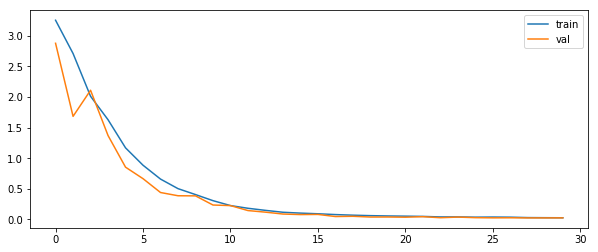

Train: Loss: 0.0280
Val: Loss: 0.0265


In [74]:
siam_model, train_losses, val_losses = train(siam_dataloaders_dict["train"], siam_dataloaders_dict["val"], 
                                             siam_model, siam_opt, criterion, n_epochs, device=device)

In [75]:
embeddings = []
labels = []
for i in tqdm(siam_ikea_dataset.item_indices):
#     print(i, siam_ikea_dataset.idx_to_item_number[i], siam_ikea_dataset.item_number_to_idx[siam_ikea_dataset.idx_to_item_number[i]])
    img, l = siam_ikea_dataset.item_dataset[i]
    img = img.unsqueeze(dim=0).to(device)
    img_emb = embedding_net(img)[0]
    embeddings.append(img_emb)
    labels.append(l)
embeddings = torch.stack(embeddings, dim=0).cpu().detach().numpy()
labels = np.array(labels)

100%|██████████| 2198/2198 [00:35<00:00, 61.35it/s]


In [85]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2, n_iter=500)

embeddings_red = pca.fit_transform(embeddings)
embeddings_2d = tsne.fit_transform(embeddings_red)

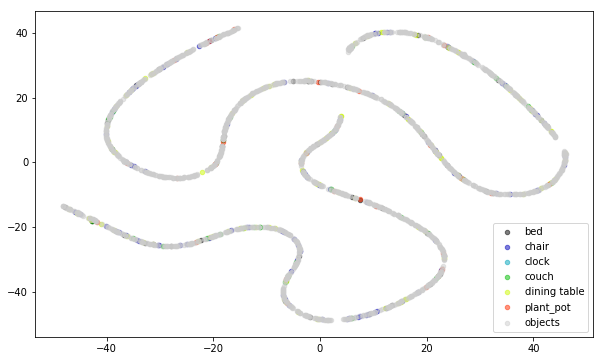

In [86]:
n = 7
cats = list(map(lambda x: "_".join(x.split("_")[1:]), ikea_dataset.classes))
colors = get_colors(plt.get_cmap("nipy_spectral"), np.linspace(0, 1, n))

plt.figure(figsize=(10, 6))

for i in range(n):
    plt.scatter(embeddings_2d[labels == i, 0], embeddings_2d[labels == i, 1], 
                c=colors[i], alpha=0.5, s=20, label=cats[i])
plt.legend()
plt.show()

In [87]:
dist_i

[0.00012997855,
 0.00021272263,
 0.00071296416,
 0.00020026963,
 0.00018308983,
 2.5311962e-05,
 5.175663e-05,
 0.00028045225,
 1.2283749e-05,
 0.00016753812,
 0.00036982383,
 2.2812326e-06,
 0.00010703612,
 0.00016979242,
 0.00035993854,
 0.0008063026,
 9.117726e-06,
 0.0005851255,
 1.7885217e-05,
 3.0658357e-05,
 0.0003645164,
 0.0002109415,
 2.63002e-06,
 7.556974e-05,
 0.00028045225,
 9.328127e-06,
 0.00014395622,
 0.00023099009,
 0.00019952431,
 2.3069864e-05,
 0.0002710639,
 0.001084238,
 0.00019679914,
 0.00014395622,
 0.000287581,
 4.83002e-05,
 2.8906066e-05,
 0.0003821371,
 6.868862e-10,
 3.8079008e-05,
 8.0380105e-06,
 0.0002791325,
 4.246783e-06,
 1.6077393e-06,
 0.00057828345,
 0.00026505828,
 7.9531426e-05,
 0.0005243425,
 5.4099215e-05,
 0.00027602626,
 4.726828e-07,
 0.00019056612,
 6.738404e-05,
 3.6662546e-05,
 3.1145667e-06,
 2.0612177e-05,
 7.332791e-05,
 0.00055471994,
 7.910162e-07,
 0.00022526868,
 0.00046971565,
 6.0569473e-05,
 0.00012857586,
 7.3680276e-05,
 0

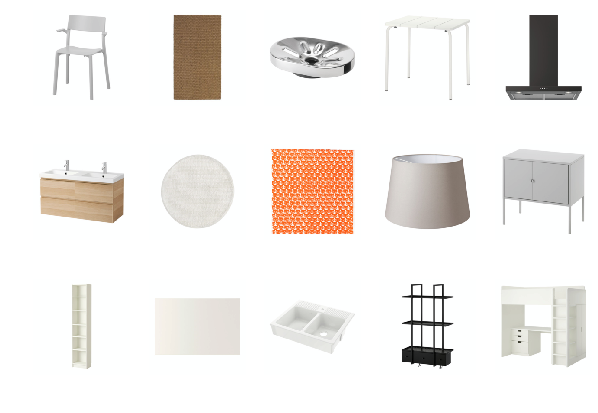

In [88]:
i = 100 #np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["902.651.09.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[idx[j]][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

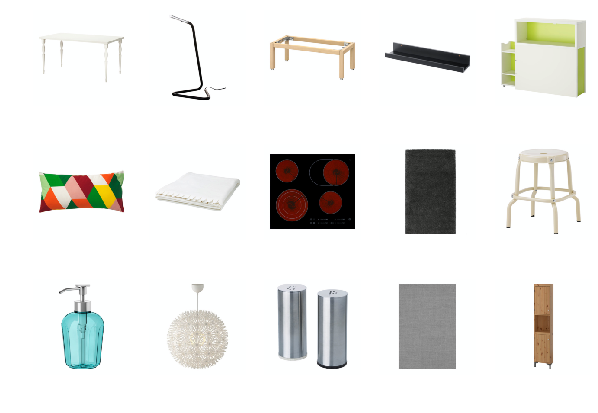

In [89]:
i = 305 #np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["902.651.09.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[idx[j]][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

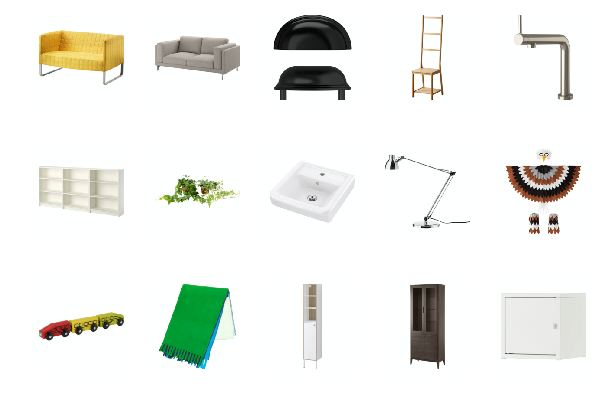

In [90]:
i = 196 #np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["902.651.09.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[idx[j]][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

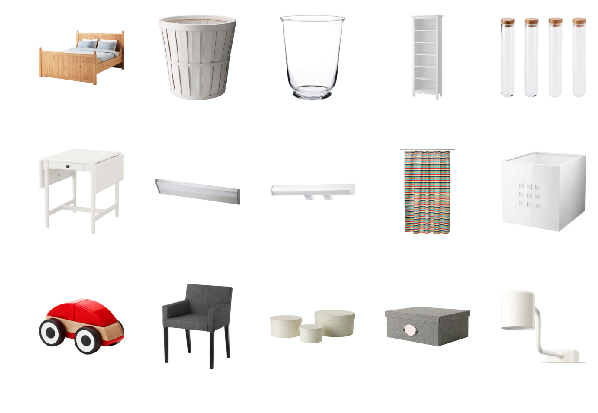

In [91]:
i = np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["690.272.95.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[idx[j]][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()

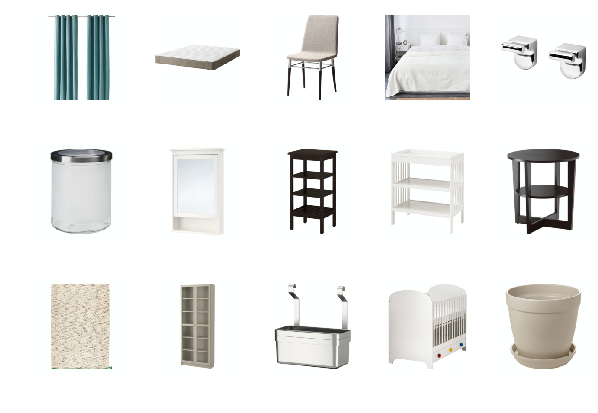

In [92]:
i = np.argwhere(np.array(idx) == siam_ikea_dataset.item_number_to_idx["202.390.10.jpg"]).ravel()[0]
emb_i = embeddings[i]

dist_i = []
for j in range(len(embeddings)):
    emb_j = embeddings[j]
    dist_i.append(((emb_i - emb_j) ** 2).sum())

plt.figure(figsize=(10, 7))
for k, j in enumerate(pd.Series(dist_i).drop_duplicates().sort_values()[:15].index):
    plt.subplot(3, 5, k + 1)
    plt.imshow(get_img(ikea_dataset[idx[j]][0]))
    plt.xlabel(np.round(dist_i[j] * 1e+7, 3))
    plt.axis('off')
plt.show()